# LSTM - Long Short-Term Memory

In [1]:
# Python ≥3.5 é necessário
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 é necessário
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 é necessário
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# imports comuns
import numpy as np
import os

# tornar os resultados reproduzíveis
np.random.seed(42)
tf.random.set_seed(42)

# Para apresentar figuras
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   onda 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + onada 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + ruído
    return series[..., np.newaxis].astype(np.float32)

In [3]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [4]:
X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape

((7000, 50, 1), (7000, 50, 10), (2000, 50, 1), (2000, 50, 10))

In [5]:
def last_time_step_mse(Y_true, Y_pred):
    return tf.reduce_mean(tf.square(Y_true[:, -1] - Y_pred[:, -1]))

np.random.seed(42)
tf.random.set_seed(42)

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.LSTM(20, return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))


Epoch 1/20


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - last_time_step_mse: 0.0963 - loss: 0.1058 - val_last_time_step_mse: 0.0359 - val_loss: 0.0563
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - last_time_step_mse: 0.0322 - loss: 0.0522 - val_last_time_step_mse: 0.0231 - val_loss: 0.0447
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - last_time_step_mse: 0.0205 - loss: 0.0421 - val_last_time_step_mse: 0.0169 - val_loss: 0.0379
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - last_time_step_mse: 0.0156 - loss: 0.0365 - val_last_time_step_mse: 0.0145 - val_loss: 0.0343
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - last_time_step_mse: 0.0141 - loss: 0.0336 - val_last_time_step_mse: 0.0128 - val_loss: 0.0320
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - last_time_step_mse: 0.0134 - loss: 0.0319 - val_last_time_step_mse: 0.0124 - val_loss: 0.0308
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - last_time_step_mse: 0.0130 - loss: 0.0308 - val_last_time_step

In [6]:
model.evaluate(X_valid, Y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - last_time_step_mse: 0.0089 - loss: 0.0240


[0.024106137454509735, 0.009040048345923424]

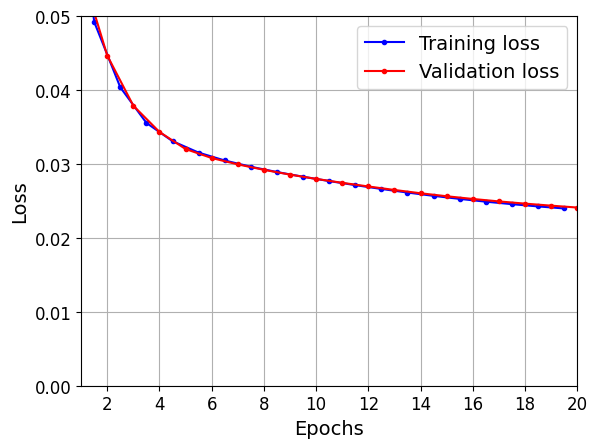

In [7]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [8]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


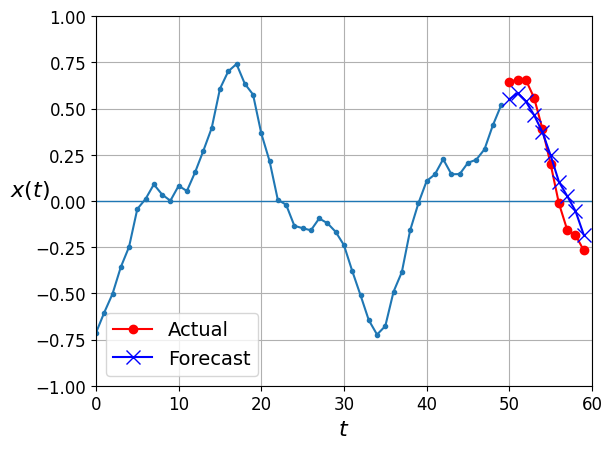

In [9]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)
    
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# GRUs

In [10]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - last_time_step_mse: 0.0932 - loss: 0.0987 - val_last_time_step_mse: 0.0424 - val_loss: 0.0531
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - last_time_step_mse: 0.0410 - loss: 0.0508 - val_last_time_step_mse: 0.0349 - val_loss: 0.0459
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - last_time_step_mse: 0.0350 - loss: 0.0450 - val_last_time_step_mse: 0.0299 - val_loss: 0.0414
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - last_time_step_mse: 0.0300 - loss: 0.0406 - val_last_time_step_mse: 0.0213 - val_loss: 0.0356
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - last_time_step_mse: 0.0210 - loss: 0.0345 - val_last_time_step_mse: 0.0164 - val_loss: 0.0316
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - last_time_step_mse: 0.0170 - loss: 0.0315 - val_last_time_step_mse: 0.0155 - val_loss: 0.0299
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - last_time_step_mse: 0.0159 - loss: 0.0301 - val_las

In [11]:
model.evaluate(X_valid, Y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - last_time_step_mse: 0.0106 - loss: 0.0232


[0.023240625858306885, 0.010456125251948833]

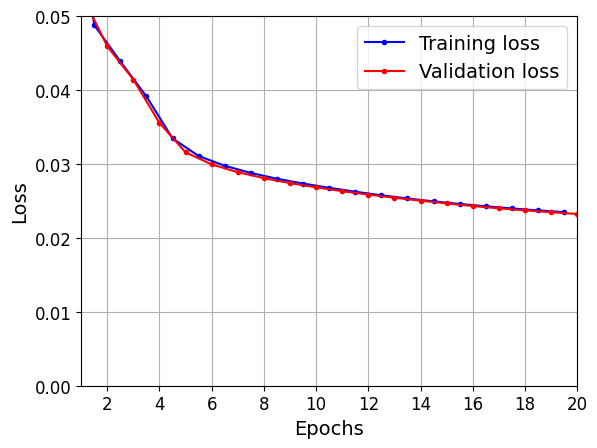

In [12]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [13]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


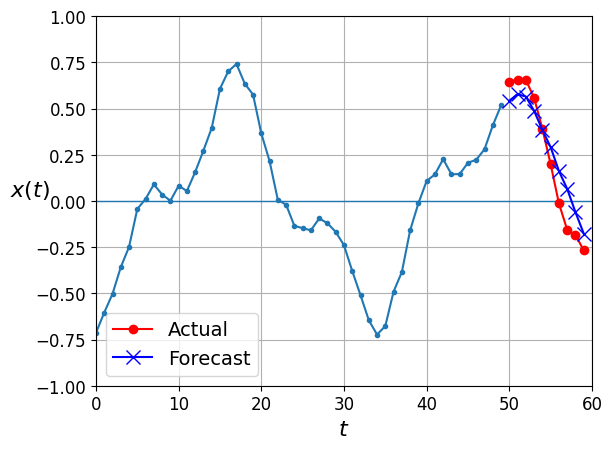

In [14]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()